In [1]:
from jax import config
config.update("jax_enable_x64", True)
import numpy as np
import jax.numpy as jnp
import jax
import equinox as eqx
import optax
import functools
import numpy as np
import matplotlib.pyplot as plt
from src.samplers import gibbs_sample_horseshoe
from src.scoring_rules import energy_score
from sgmcmcjax.diffusions import psgnht, pgsgld
from tqdm import tqdm
from functools import partial
from sgmcmcjax.ksd import imq_KSD
import equinox as eqx
import functools
import copy
np.random.seed(42)

In [2]:
class NN_hyperprior(eqx.Module):
    # Hyperpriors should be a list with L elements, each element is a jax.array of shape (1 + # units in that layer)
    hyperpriors: list

class cGAN(eqx.Module):
    layers: list

    def __init__(self, key, noise_dim, input_dim, output_dim=1, hidden_dim=20):
        key1, key2, key3 = jax.random.split(key, 3)
        self.layers = [eqx.nn.Linear(input_dim + noise_dim, hidden_dim, key=key1),
                       eqx.nn.Linear(hidden_dim, hidden_dim, key=key2),
                       eqx.nn.Linear(hidden_dim, output_dim, key=key3)]

    def __call__(self, x):
        for layer in self.layers[:-1]:
            x = jax.nn.leaky_relu(layer(x))
        return self.layers[-1](x)

is_linear = lambda x: isinstance(x, eqx.nn.Linear)

get_weight_matrices = lambda m: [jnp.concatenate((x.weight, x.bias.reshape(-1,1)), axis=1)
                        for x in jax.tree_util.tree_leaves(m, is_leaf=is_linear)
                        if is_linear(x)]

def build_flat_covar_mat(nn_dims, nn_hp):
    full_covar_mat = []

    for layer_idx in range(len(nn_dims) - 1):
        inv_tau_sq = 1 / (nn_hp.hyperpriors[layer_idx][0] ** 2)
        inv_lambda_sq = 1 /  (nn_hp.hyperpriors[layer_idx][1:] ** 2)
        full_covar_mat.append(inv_tau_sq * jnp.concatenate([jnp.repeat(inv_lambda_sq, nn_dims[layer_idx][1] - 1), inv_lambda_sq]))

    full_covar_mat.append(jnp.ones(nn_dims[-1][1]))

    return jnp.concatenate(full_covar_mat)

In [3]:
key = jax.random.PRNGKey(0)
key, subkey = jax.random.split(key)

n=10
p=100
noise_dim = 2
m = 100

hidden_dim = 30
output_dim = 1
init_model = cGAN(key, input_dim=p, noise_dim=noise_dim, hidden_dim=hidden_dim, output_dim=output_dim)
init_nn_params, static = eqx.partition(init_model, eqx.is_inexact_array)
init_flat_nn_param, nn_unflatten_fn = jax.flatten_util.ravel_pytree(init_model)

true_model = copy.deepcopy(init_model)
true_nn_params, _ = eqx.partition(true_model, eqx.is_inexact_array)

def gen_mask(shape,slice):
    mask = jnp.ones(shape)
    mask = mask.at[slice].set(0.0)
    return mask

for layer_idx in range(len(true_nn_params.layers)-1):
    for masked_node_idx in range(0,true_nn_params.layers[layer_idx].weight.shape[0],3):
        masked_weight_slice = jnp.s_[masked_node_idx, :]
        true_nn_params.layers[layer_idx] = eqx.tree_at(lambda l:l.weight, true_nn_params.layers[layer_idx], 
                                    replace_fn=lambda x: jnp.multiply(x,gen_mask(x.shape, masked_weight_slice)))

        masked_bias_slice = jnp.s_[masked_node_idx]
        true_nn_params.layers[layer_idx] = eqx.tree_at(lambda l:l.bias, true_nn_params.layers[layer_idx], 
                                    replace_fn=lambda x: jnp.multiply(x,gen_mask(x.shape, masked_bias_slice)))

true_model = eqx.combine(true_nn_params, static)

key, subkey1, subkey2 = jax.random.split(key, 3)
X = jax.random.normal(subkey1, shape=(n,p)) 
z = jax.random.normal(subkey2, shape=(n,noise_dim))
X_new = np.concatenate([X,z], axis=-1)
y = jax.vmap(true_model)(X_new) 

Array(0.01954457, dtype=float64)

In [4]:
nn_hp = NN_hyperprior([jnp.ones(hidden_dim + 1), # + 1 for the tau  
                       jnp.ones(hidden_dim + 1),
                       jnp.ones(output_dim + 1)])

init_flat_hs_param, hs_unflatten_fn = jax.flatten_util.ravel_pytree(nn_hp)
init_flat_nn_param, nn_unflatten_fn = jax.flatten_util.ravel_pytree(init_nn_params)

def hs_logprior_fn(nn_model, hyperprior_params):
    """Compute the value of the log-prior density function.
    Hyperpriors are the hyperpriors for each layer"""
    assert(len(nn_model.layers) == len(hyperprior_params.hyperpriors))
    hs_prior = hyperprior_params.hyperpriors
    log_prior = 0
    weight_matrices = get_weight_matrices(nn_model)[:-1] #Exclude the last layer
    
    # Deal with HS priors in the hidden layers
    for layer_idx, weight_matrix in enumerate(weight_matrices):
        tau_l = hs_prior[layer_idx][0]
        dim_units_prev_layer = weight_matrix.shape[1]
        for unit_idx, weight_layer in enumerate(weight_matrix):
            scaling = jnp.square(tau_l) * jnp.square(hs_prior[layer_idx][unit_idx + 1])
            log_prior += jax.scipy.stats.multivariate_normal.logpdf(weight_layer, mean=jnp.zeros(dim_units_prev_layer), cov=scaling * jnp.eye(dim_units_prev_layer))

    # For last layer, just add a broad gaussian prior
    dim_units_prev_layer = get_weight_matrices(nn_model)[-1].shape[1]
    for _, weight_layer in enumerate(get_weight_matrices(nn_model)[-1]):
        log_prior += jax.scipy.stats.multivariate_normal.logpdf(weight_layer, mean=jnp.zeros(dim_units_prev_layer), cov= jnp.eye(dim_units_prev_layer)) 

    return log_prior

In [5]:
def lfi_log_lik(model, x, y, z):
    x = jnp.broadcast_to(x, shape=(m,n,p))
    x = jnp.concatenate([x,z], -1)
    sims = jax.vmap(jax.vmap(model))(x)
    log_lik = - jax.vmap(energy_score, (0,0), 0)(y.reshape(n,1,1), sims.reshape(n,m,1)).sum()
    return log_lik
lfi_log_lik = functools.partial(lfi_log_lik, x=X, y=y)

@functools.partial(jax.jit, static_argnums=1)
def lfi_joint_log_post(nn_params, static, z, hyperprior_params):
    # x should be (N, D), y should be (N, 1)
    # D = 1 for now
    nn_model = eqx.combine(nn_params, static)

    return (lfi_log_lik(model=nn_model, z=z) + hs_logprior_fn(nn_model, hyperprior_params)) # negative log posterior

def energy_fn(key, flat_nn_params, flat_hyperpriors, nn_unflatten_fn, hs_unflatten_fn, static):
    z = jax.random.normal(key=key, shape=(m,n,noise_dim))
    nn_params = nn_unflatten_fn(flat_nn_params)
    hyperprior_params = hs_unflatten_fn(flat_hyperpriors)
        
    energy = lfi_joint_log_post(nn_params, static, z, hyperprior_params)
    return energy
energy_fn = functools.partial(energy_fn, static=static, nn_unflatten_fn=nn_unflatten_fn, hs_unflatten_fn=hs_unflatten_fn)



@jax.jit
def gibbs_kernel(key, flat_hs_params, betas):
    hs_params = hs_unflatten_fn(flat_hs_params)
    nn_params = nn_unflatten_fn(betas)
    nn_weights = get_weight_matrices(nn_params)
    
    new_flat_hs_params = []
    for layer_idx in range(len(nn_dims) - 1):
        col_idx = 0 # Which index to use for the sampling, we could use any of the columns
        # Do this columnwise now
        key, subkey = jax.random.split(key)
        taus_sq, lambdas_sq = hs_params.hyperpriors[layer_idx][0] ** 2, hs_params.hyperpriors[layer_idx][1:] ** 2

        _, _, taus_sq, lambdas_sq = gibbs_sample_horseshoe(subkey,
                                                        taus_sq, 
                                                        lambdas_sq, 
                                                        nn_weights[layer_idx][:,col_idx], 
                                                        nn_dims[layer_idx][0])
        new_flat_hs_params.append(jnp.concatenate([jnp.sqrt(taus_sq), jnp.sqrt(lambdas_sq)]))
    
    new_flat_hs_params.append(jnp.ones(output_dim + 1))
    new_flat_hs_params = jnp.concatenate(new_flat_hs_params)

    return new_flat_hs_params

@partial(jax.jit, static_argnames=("use_iden"))
def sgld_kernel(key, 
                idx,
                sgld_state,
                flat_hs_param,
                use_iden = False):

    lfi_energy = lambda param : jax.jit(energy_fn)(key, param, flat_hs_param)
    grad_log_post = jax.jit(jax.value_and_grad(lfi_energy))
    if use_iden:
        G = jnp.ones(flat_dim)
    else:
        hs_param = hs_unflatten_fn(flat_hs_param)
        G = build_flat_covar_mat(nn_dims, hs_param)

    loss, state_grad = grad_log_post(get_params(sgld_state))
    sgld_state = update(idx, subkey, state_grad, G, sgld_state)
    
    return get_params(sgld_state), sgld_state, loss


@partial(jax.jit, static_argnames=("use_iden"))
def sgd_kernel(key, flat_hs_param, flat_nn_param, opt_state, use_iden=False):
    flat_dim = len(flat_nn_param)
    
    lfi_energy = lambda param : - jax.jit(energy_fn)(key, param, flat_hs_param)
    grad_log_post = jax.jit(jax.value_and_grad(lfi_energy))
    if use_iden:
        G = jnp.ones(flat_dim)
    else:
        hs_param = hs_unflatten_fn(flat_hs_param)
        G = build_flat_covar_mat(nn_dims, hs_param)
    loss, grads = grad_log_post(flat_nn_param)

    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(flat_nn_param, updates)
    
    return params, opt_state, loss

@jax.jit
def pred_kernel(key, flat_hs_param, flat_nn_param):
    lfi_energy = lambda param : jax.jit(energy_fn)(key, param, flat_hs_param)
    grad_log_post = jax.jit(jax.value_and_grad(lfi_energy))
    loss, grads = grad_log_post(flat_nn_param)
    
    return grads, loss

In [6]:
optimizer = optax.adam(1e-4)

initial_state = {
    "hs_prior": init_flat_hs_param,
    "betas": init_flat_nn_param,
    "opt_state": optimizer.init(init_flat_nn_param),
    "loss" : jnp.nan,
    "pred_loss" : jnp.nan,
    "pred_grads" : jnp.nan
}

def opt_loop(rng_key, initial_state, num_samples, use_iden):    
    state = initial_state
    states = [state]
    for i in tqdm(range(num_samples)):
        state = state.copy()
        rng_key, rng_key_gibbs, rng_key_sgd, rng_key_pred = jax.random.split(rng_key, 4)
        state['hs_prior'] = gibbs_kernel(rng_key_gibbs, state['hs_prior'], state['betas'])
        state['betas'], state['opt_state'], state['loss'] = sgd_kernel(rng_key_sgd, state['hs_prior'],state['betas'],state['opt_state'], use_iden = use_iden)
        state['pred_grads'], state['pred_loss'] = pred_kernel(rng_key_pred, state['hs_prior'], state['betas'])
        if jnp.isnan(state['betas']).any():
            print("NANs encountered! at iteration {}".format(i))
            break
        states.append(state)

    return states

init_fn, update, get_params = pgsgld(1e-4)
update = jax.jit(update)

def sampling_loop(rng_key, states, num_samples, use_iden):
    state = states[-1].copy()
    sgld_state = init_fn(state['betas'])
    state["opt_state"] = sgld_state
    
    for i in tqdm(range(num_samples)):
        state = state.copy()
        rng_key, rng_key_gibbs, rng_key_sgld, rng_key_pred = jax.random.split(rng_key, 4)
        state['hs_prior'] = gibbs_kernel(rng_key_gibbs, state['hs_prior'], state['betas'])
        state['betas'], state['opt_state'], state['loss'] = sgld_kernel(rng_key_sgld, i, state["opt_state"], state["hs_prior"], use_iden = use_iden)
        state['pred_grads'], state['pred_loss'] = pred_kernel(rng_key_pred, state['hs_prior'], state['betas'])

        if jnp.isnan(state['betas']).any():
            print("NANs encountered! at iteration {}".format(i))
            break
        states.append(state)

    return states

flat_dim = len(init_flat_nn_param)
nn_dims = [x.shape for x in get_weight_matrices(init_model)]

sample_key = jax.random.PRNGKey(42)
states_precon = sampling_loop(sample_key, [initial_state], 6000, False)
states_iden = sampling_loop(sample_key, [initial_state], 6000, True)

100%|██████████| 6000/6000 [05:26<00:00, 18.36it/s]


In [8]:
ksd_lists = []
pred_lists = []

for states in [states_precon, states_iden]:
    betas_list = jnp.array([s['betas'] for s in states[101:]])
    ksd_grads_list = jnp.array([s['pred_grads'] for s in states[101:]])
    pred_list = jnp.array([s['pred_loss'] for s in states[101:]])
    
    ksd_list = [imq_KSD(betas_list[i:i+500], ksd_grads_list[i:i+500]) for i in range(0, 5000, 500)]
    ksd_lists.append(ksd_list)

    mean_pred_list = [-jnp.mean(pred_list[i:i+500]) for i in range(0, 5000, 500)]
    pred_lists.append(mean_pred_list)

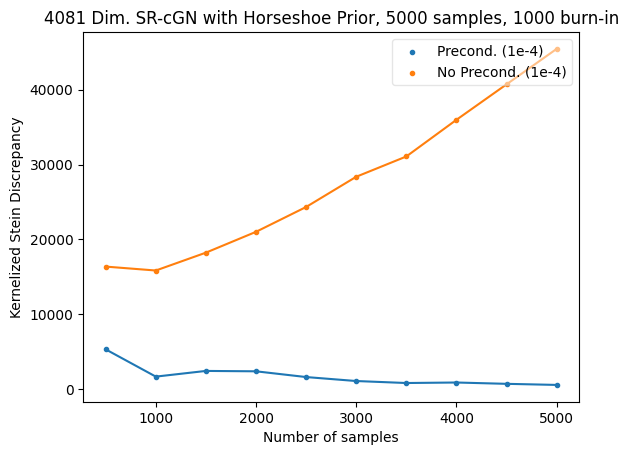

In [9]:
fig, ax = plt.subplots()

txt_label =['Precond. (1e-4)', 'No Precond. (1e-4)']
n_samples = 5000
y_plotted = [ksd_lists[0], ksd_lists[1]]
x_boom = list(range(500, 5001, 500))
for idx, y in enumerate(y_plotted[:]):
    plt.scatter(x_boom, y, marker='.', label=txt_label[idx])
    plt.plot(x_boom,y)



plt.legend(loc='upper right',framealpha=0.5)
plt.title('4081 Dim. SR-cGN with Horseshoe Prior, 5000 samples, 1000 burn-in')
plt.xlabel('Number of samples')
plt.ylabel('Kernelized Stein Discrepancy') 
plt.savefig('exp_11_cGAN_ksd.png')